In [51]:
# Initialise variables and imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from room_simulation import Simulation
from sine_dataset import SineData
from network import SSLConvNet as ConvNet
from network import SSLConvNetCosLoss as ConvNetCosLoss
from logger import Logger
import matplotlib.pyplot as plt
import math
import seaborn as sns

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
MODELS_PATH = "../models/"
DATA_PATH = "../thesis_data/"
BATCH_SIZE = 5
BATCH_SIZE_MSECOS = 25
TEST_SIZE = 10000
EPOCHS = int(TEST_SIZE/BATCH_SIZE)
EPOCHS_MSECOS = int(TEST_SIZE/BATCH_SIZE_MSECOS)
NR_MICS = 2
RAD = 50
RADII = [50, 500, 5000]
ROOM_SIMS = []
DATASETS = []
MIC_L_DIST = (11, 10)
MIC_R_DIST = (11, 10)
ABSORPTION = 0.0
MIN_FREQ = 20
MAX_FREQ = 20000
SAMPLE_RATE = int(MAX_FREQ*2.2)
TIME = 1
MIN_LENGTH = 65000
MIN_LENGTH_MSECOS = 48000
TO_RAD = np.pi/180
TO_DEG = 180/np.pi

# Define custom loss function
class CosBorderLoss(torch.nn.Module):

    def __init__(self):
        super(CosBorderLoss, self).__init__()

    def forward(self, pred, target):
        radial = torch.abs(torch.cos(pred-target) - torch.cos(target-target))
        border = nn.functional.relu(pred-2*np.pi) + nn.functional.relu(-pred)
        return torch.sum(radial + border)

def calcCircumPos(x1, y1, r, theta):
    xPositions = x1 + r*torch.sin(theta)
    xPositions = r*2-xPositions #Flip x-coordinates
    yPositions = y1 + r*(1-torch.cos(theta))
    yPositions = r*2-yPositions #Flip y-coordinates
    return xPositions, yPositions

def calcCircumAngle(cx, cy, x, y):
    theta = torch.atan2(y-cy, cx-x) + np.pi/2
    return theta

In [ ]:
for rad in RADII:
    print(rad)
    roomSim = Simulation(SAMPLE_RATE, rad, ABSORPTION,MIC_L_DIST, MIC_R_DIST, NR_MICS)
    ROOM_SIMS.append(roomSim)

    DATASETS.append(SineData(BATCH_SIZE, roomSim, TIME, MIN_LENGTH, MAX_FREQ))

roomSimMSECos = ROOM_SIMS[0]
datasetMSECos = SineData(BATCH_SIZE_MSECOS, roomSimMSECos, TIME, MIN_LENGTH_MSECOS, MAX_FREQ)

In [ ]:
# Create networks
nets = []
for rad in RADII:
    print(rad)
    net = ConvNet(MIN_LENGTH).double()
    net.load_state_dict(torch.load(MODELS_PATH+"ConvNet_Rad"+str(rad)+".pt", map_location="cpu"))
    net.eval()
    nets.append(net)

MSENet = ConvNet(MIN_LENGTH_MSECOS).double()
MSENet.load_state_dict(torch.load(MODELS_PATH+"ConvNet_MSELoss.pt", map_location="cpu"))
MSENet.eval()

CosNet = ConvNetCosLoss(MIN_LENGTH_MSECOS).double()
CosNet.load_state_dict(torch.load(MODELS_PATH+"ConvNet_CosLoss.pt", map_location="cpu"))
CosNet.eval()


In [ ]:
################
# EXPERIMENT 1 #
################

CosLoss = CosBorderLoss()
MSELoss = nn.MSELoss()
CosLosses = np.zeros((2, EPOCHS_MSECOS))
MSELosses = np.zeros((2, EPOCHS_MSECOS))
dataLoader = DataLoader(datasetMSECos, batch_size=BATCH_SIZE_MSECOS)

for i in range(EPOCHS_MSECOS):
    if i%100 == 0:
        print("Epoch "+str(i)+"/"+str(EPOCHS_MSECOS))
    
    # Retrieve all input data and labels
    inL, inR, labelX, labelY, labelAzi = next(iter(dataLoader))
    inL = inL.double().to(device)
    inR = inR.double().to(device)
    labelX = labelX.double().to(device)
    labelY = labelY.double().to(device)
    labelAzi = labelAzi.double().to(device)

    # Compute MSE and Cos losses for coordinate network
    MSENet = MSENet.to(device)
    
    outputXMSE, outputYMSE = MSENet(inL, inR)
    outputXMSE = torch.squeeze(outputXMSE)
    outputYMSE = torch.squeeze(outputYMSE)
    
    outputAziMSE = calcCircumAngle(50, 50, outputXMSE, outputYMSE)
    print("OUT   X: "+str(outputXMSE))
    print("LABEL X: "+str(labelX))
    print("OUT   Y: "+str(outputYMSE))
    print("LABEL Y: "+str(labelY))
    
    CosLosses[0,i] = CosLoss(outputAziMSE, labelAzi)
    MSELosses[0,i] = MSELoss(outputXMSE, labelX) + MSELoss(outputYMSE, labelY)
    
     
    # Compute MSE and Cos losses for angle network
    CosNet = CosNet.to(device)
    
    outputAziCos = CosNet(inL, inR)
    outputAziCos = torch.squeeze(outputAziCos)
    outputXCos, outputYCos = calcCircumPos(50, 0, 50, outputAziCos)
    print("COS   Y: "+str(outputYCos))
    
    CosLosses[1,i] = CosLoss(outputAziCos, labelAzi)
    MSELosses[1,i] = MSELoss(outputXCos, labelX) + MSELoss(outputYCos, labelY)

del MSENet, CosNet, inL, inR, labelX, labelY, labelAzi

np.save(DATA_PATH+"exp1_MSE_outcomes", MSELosses)
np.save(DATA_PATH+"exp1_Cos_outcomes", CosLosses)

In [ ]:
################
# EXPERIMENT 2 #
################

MSELosses = np.zeros((len(DATASETS), len(nets), EPOCHS))

for i,dataset in enumerate(DATASETS):
    print("Dataset "+str(i))

    dataLoader = DataLoader(dataset, batch_size = BATCH_SIZE)
    
    for j,net in enumerate(nets):
        print("Network "+str(j))

        net.to(device)

        for k in range(EPOCHS):
            if k%100 == 0:
                print("Epoch "+str(k)+"/"+str(EPOCHS))
            
            inL, inR, labelX, labelY, _ = next(iter(dataLoader))
            inL = inL.double().to(device)
            inR = inR.double().to(device)
            labelX = labelX.double().to(device)
            labelY = labelY.double().to(device)

            outputX, outputY = net(inL, inR)
            outputX = torch.squeeze(outputX)
            outputY = torch.squeeze(outputY)

            MSELosses[i,j,k] = MSELoss(outputX, labelX) + MSELoss(outputY, labelY)

        del net, inL, inR, labelX, labelY

np.save(DATA_PATH+"exp2_outcomes", MSELosses)

In [153]:
################
# EXPERIMENT 3 #
################

roomSim = Simulation(SAMPLE_RATE, 50, ABSORPTION,MIC_L_DIST, MIC_R_DIST, NR_MICS)
datasets = []
datasetLowFreq = SineData(BATCH_SIZE_MSECOS, roomSim, TIME, MIN_LENGTH_MSECOS, 20, 1500)
datasetMedFreq = SineData(BATCH_SIZE_MSECOS, roomSim, TIME, MIN_LENGTH_MSECOS, 1500, 3000)
datasetHigFreq = SineData(BATCH_SIZE_MSECOS, roomSim, TIME, MIN_LENGTH_MSECOS, 3000, 20000)

In [170]:
import pyroomacoustics.doa as pra

inL, inR, _, _, azi = datasetLowFreq.__getitem__(0)
inL = inL.numpy()
inR = inR.numpy()
threshold = 2e-12

inL[np.where(np.abs(inL) < threshold)] = 0
inR[np.where(np.abs(inR) < threshold)] = 0

-0.47727272727272724
0.20688505861334258


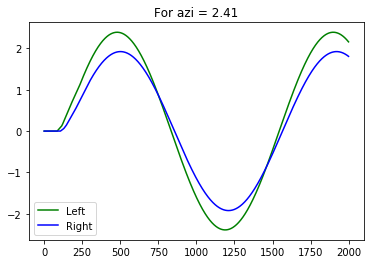

In [173]:
# Compute ITD
non_zero_ind_inL = np.argmax(inL > 0)
non_zero_ind_inR = np.argmax(inR > 0)

ITD_msec = (non_zero_ind_inL/SAMPLE_RATE - non_zero_ind_inR/SAMPLE_RATE) * 1000
print(ITD_msec)

# Compute IID
peak_inL_idxs = pra.detect_peaks(inL)
peak_inR_idxs = pra.detect_peaks(inR)

# Make sure peak arrays are of same length
len_diff = len(peak_inL_idxs) - len(peak_inR_idxs)
if len_diff != 0:
    if len_diff > 0:
        peak_inL_idxs = peak_inL_idxs[len_diff:]
    else:
        peak_inR_idxs = peak_inR_idxs[abs(len_diff):]

IIDs = inL[peak_inL_idxs] - inR[peak_inR_idxs]
mean_IID = np.mean(IIDs)
print(mean_IID)

# Plot signals to double check
plt.plot(inL[:2000], color = 'g', label = "Left")
plt.plot(inR[:2000], color = 'b', label = "Right")
plt.legend()
plt.title("For azi = "+str(np.round(azi,2)))
plt.show()

In [ ]:
MSELosses_exp1 = np.load(DATA_PATH+"exp1_MSE_outcomes.npy")
CosLosses_exp1 = np.load(DATA_PATH+"exp1_Cos_outcomes.npy")

print(MSELosses_exp1.shape)
print(np.mean(MSELosses_exp1, axis = 1))
print(np.std(MSELosses_exp1, axis = 1))
# print(MSELosses_exp1[:])

print(CosLosses_exp1.shape)
print(np.mean(CosLosses_exp1, axis = 1))
print(np.std(CosLosses_exp1, axis = 1))
# print(CosLosses_exp1[:])

In [ ]:
losses_exp2 = np.load(DATA_PATH+"exp2_outcomes.npy")

print(losses_exp2.shape)
print(np.mean(losses_exp2[0], axis=1))
print(np.mean(losses_exp2[1], axis=1))
print(np.mean(losses_exp2[2], axis=1))